# Visual validation notebook

We visually check some results for selected `DisNo.` values, comparing a generated geometry source against a benchmark (GAUL or GDIS).

---


## Imports and configuration

In [1]:
import random
import re
import tomllib
from dataclasses import fields
from pathlib import Path
from typing import Literal

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

from validation.geom_indices import GeomIndices
from validation.io import load_benchmark

with open('config.toml', 'rb') as f:
    config = tomllib.load(f)

In [2]:
OUTPUT_DIR = Path(config['path']['validation_output_dir'])
FILENAME_PATTERN = r'^([a-z]+_[a-z]+)_([a-z]+)_batch([1-5])(?:_dissolved)?\.csv$'
BATCH_DIR = Path(config['path']['batch_dir'])
VISUAL_VALIDATION_DIR = Path('validation_samples')
GEOM_INDICES_LIST = [f.name for f in fields(GeomIndices)]

## Helpers: filename parsing and IO

In [3]:
def validate_output_filename(filename: str | Path,
                             filename_pattern=FILENAME_PATTERN):
    """Check if a filename matches the expected pattern."""
    if isinstance(filename, Path):
        filename = filename.name
    elif not isinstance(filename, str):
        raise TypeError("Filename must be a string or Path object.")
    return bool(re.match(filename_pattern, filename))


def _parse_output_filename(filename, flexible_pattern=FILENAME_PATTERN):
    """Parse filename using flexible regex and extract components."""
    match = re.match(flexible_pattern, filename)
    if match:
        geom_source = match.group(1)  # e.g., "llm_gadm", etc.
        benchmark = match.group(2)  # e.g., "gaul", "gdis"
        batch_number = int(match.group(3))
        dissolved = filename.endswith('_dissolved.csv')
        return geom_source, benchmark, batch_number, dissolved
    return None


def get_output_file_list(output_dir: str | Path):
    """Get a list of output files matching the expected pattern; warn and ignore others."""
    output_dir = Path(output_dir)
    output_files = [f.name for f in output_dir.glob('*.csv')]
    matched = [fn for fn in output_files if validate_output_filename(fn)]
    if len(matched) != len(output_files):
        bad = sorted(set(output_files) - set(matched))
        if bad:
            print(f"Warning: ignoring non-matching CSV files: {bad}")
    return matched


def get_output_files_metadata(output_list: list[str]):
    """Get a dataframe of output files metadata."""
    metadata = [_parse_output_filename(fn) for fn in output_list]
    return pd.DataFrame(
        index=output_list,
        columns=['geom_source', 'benchmark', 'batch_number', 'dissolved'],
        data=metadata
    )


def get_output_data(output_list: list[str],
                    output_dir: str | Path = OUTPUT_DIR):
    """Get a dataframe of output data."""
    output_data = pd.DataFrame()
    for fn in output_list:
        df_tmp = pd.read_csv(output_dir / fn)
        output_data = pd.concat([output_data, df_tmp], axis=0)
    return output_data.reset_index(drop=True)

## Discover available output CSVs

In [4]:
output_file_list = get_output_file_list(OUTPUT_DIR)
output_files_metadata = get_output_files_metadata(output_file_list)
output_files_metadata

,geom_source,benchmark,batch_number,dissolved
gdis_gadm_gaul_batch1.csv,gdis_gadm,gaul,1,False
gdis_gadm_gaul_batch1_dissolved.csv,gdis_gadm,gaul,1,True
gdis_gadm_gaul_batch2.csv,gdis_gadm,gaul,2,False
gdis_gadm_gaul_batch2_dissolved.csv,gdis_gadm,gaul,2,True
gdis_gadm_gaul_batch3.csv,gdis_gadm,gaul,3,False
...,...,...,...,...
llm_wiki_gdis_batch3_dissolved.csv,llm_wiki,gdis,3,True
llm_wiki_gdis_batch4.csv,llm_wiki,gdis,4,False
llm_wiki_gdis_batch4_dissolved.csv,llm_wiki,gdis,4,True
llm_wiki_gdis_batch5.csv,llm_wiki,gdis,5,False


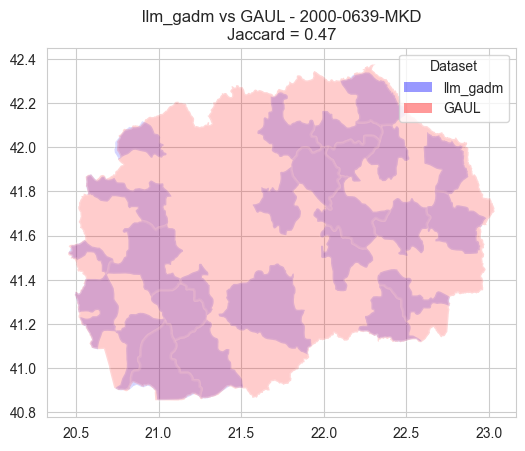

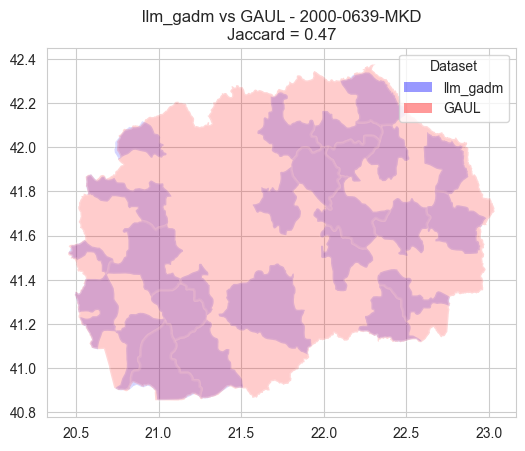

In [8]:
def get_disno_sample(
        sample_size: int,
        geom_source: Literal['gdis_gadm', 'llm_gadm', 'llm_osm', 'llm_wiki'],
        benchmark: Literal['GAUL', 'GDIS'],
        batch_number: int,
        dissolved: bool | None = None,
        metadata: pd.DataFrame = output_files_metadata,
        seed: int | None = None
):
    file_selection = metadata[
        (metadata['geom_source'] == geom_source) &
        (metadata['benchmark'] == benchmark.lower()) &
        (metadata['batch_number'] == batch_number)
        ]
    if dissolved is not None:
        file_selection = file_selection[
            file_selection['dissolved'] == dissolved]
    file_selection = file_selection.index.to_list()
    df = get_output_data(file_selection)
    # get unique disno
    disno_list = df['dis_no'].unique().tolist()
    # sample unique disno
    if seed is not None:
        random.seed(seed)
    disno_sample = random.sample(disno_list, sample_size)
    df = df[df['dis_no'].isin(disno_sample)]
    df['dissolved'] = df['name'].apply(lambda x: x.startswith('['))

    return disno_sample, df


def load_batch(
        geom_source,
        batch_number,
        usecols=None,
        disno_sample: list | None = None
) -> gpd.GeoDataFrame:
    gpkg_path = BATCH_DIR / f"{geom_source}_{batch_number}.gpkg"
    # Try modern fast path first; gracefully fall back if unsupported
    try:
        gdf_batch = gpd.read_file(
            gpkg_path,
            columns=usecols,
            use_arrow=True
        )
    except TypeError:
        gdf_batch = gpd.read_file(gpkg_path)
        if usecols is not None:
            # Keep only requested columns if present
            cols = [c for c in usecols if c in gdf_batch.columns]
            gdf_batch = gdf_batch[cols]
    if disno_sample is not None:
        gdf_batch = gdf_batch[gdf_batch['DisNo.'].isin(disno_sample)]
    return gdf_batch


def generate_visual_validation_df(
        geom_source: Literal['gdis_gadm', 'llm_gadm', 'llm_osm', 'llm_wiki'],
        benchmark: Literal['GAUL', 'GDIS'],
        batch_number: int | None = None,
        seed: int | None = 42,
        benchmark_path: str | Path | None = None,
        dissolved: bool = True,
        save_output: bool = True
):
    """Generate and save visual validation artifacts, and return fig/ax for display."""
    if seed is not None:
        random.seed(seed)
    if batch_number is None:
        batch_number = random.randint(1, 5)

    # Resolve benchmark_path dynamically if not provided
    if benchmark_path is None:
        if benchmark.upper() == 'GAUL':
            benchmark_path = Path(config['path']['emdat_gaul_path'])
        elif benchmark.upper() == 'GDIS':
            benchmark_path = Path(config['path']['gdis_path'])
        else:
            raise ValueError(f"Unknown benchmark: {benchmark}")

    disnos, df_disno = get_disno_sample(
        sample_size=1,
        geom_source=geom_source,
        benchmark=benchmark,
        batch_number=batch_number,
        seed=seed,
        dissolved=dissolved
    )

    if not disnos:
        raise ValueError("No DisNo. found for the requested selection. Check output files and filters.")

    stem_name = f"{geom_source}_{batch_number}_{benchmark}_{disnos[0]}"
    output_dir = VISUAL_VALIDATION_DIR / stem_name
    output_dir.mkdir(parents=True, exist_ok=True)

    # load batch geometries
    gdf_batch = load_batch(
        geom_source,
        batch_number,
        usecols=['DisNo.', 'geometry'],
        disno_sample=disnos
    )
    if gdf_batch.empty:
        raise ValueError("Batch GeoDataFrame is empty for the selected DisNo.")
    gdf_batch['dataset'] = geom_source

    gdf_benchmark = load_benchmark(
        benchmark=benchmark,
        benchmark_path=benchmark_path,
        keep_columns=['DisNo.', 'geometry']
    )
    gdf_benchmark = gdf_benchmark[gdf_benchmark['DisNo.'].isin(disnos)]
    if gdf_benchmark.empty:
        raise ValueError("Benchmark GeoDataFrame is empty for the selected DisNo.")
    gdf_benchmark['dataset'] = benchmark

    # Align CRS if needed
    try:
        if gdf_batch.crs and gdf_benchmark.crs and gdf_batch.crs != gdf_benchmark.crs:
            gdf_benchmark = gdf_benchmark.to_crs(gdf_batch.crs)
    except Exception:
        pass

    gdf_merged = gpd.GeoDataFrame(pd.concat([gdf_batch, gdf_benchmark], axis=0))

    color_map = {
        geom_source: 'blue',
        benchmark: 'red'
    }

    ax = gdf_merged.plot(
        alpha=.2,
        lw=2.,
        color=gdf_merged['dataset'].map(color_map)
    )

    # Safe title with optional Jaccard
    if df_disno.empty or 'jaccard' not in df_disno:
        title_jaccard = "Jaccard = n/a"
    else:
        try:
            title_jaccard = f"Jaccard = {df_disno['jaccard'].iloc[0]:.2f}"
        except Exception:
            title_jaccard = "Jaccard = n/a"
    ax.set_title(f"{geom_source} vs {benchmark} - {disnos[0]}\n{title_jaccard}")

    # Manually add legend
    legend_elements = [
        Patch(facecolor='blue', edgecolor='none', alpha=0.4, label=geom_source),
        Patch(facecolor='red', edgecolor='none', alpha=0.4, label=benchmark)
    ]
    ax.legend(handles=legend_elements, title='Dataset', loc='best')

    fig = ax.get_figure()
    if save_output:
        fig.savefig(output_dir / f"{stem_name}.png")
        # Do not close here since we return the figure for display
        df_disno.to_csv(output_dir / f"{stem_name}.csv", index=False)
        gdf_merged.to_file(output_dir / f"{stem_name}.gpkg")
    return fig, ax


fig, ax = generate_visual_validation_df(
    geom_source='llm_gadm',
    benchmark='GAUL',
    batch_number=1,
    seed=None,
    save_output=False
)
fig

Generating sample 1/5: llm_osm vs GDIS - batch 1
Generating sample 2/5: llm_wiki vs GDIS - batch 5
Generating sample 3/5: llm_osm vs GAUL - batch 5
Generating sample 4/5: llm_osm vs GAUL - batch 3
Generating sample 5/5: llm_osm vs GAUL - batch 1


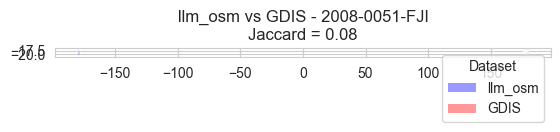

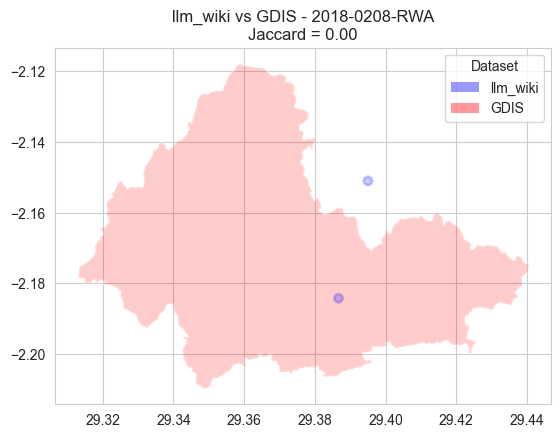

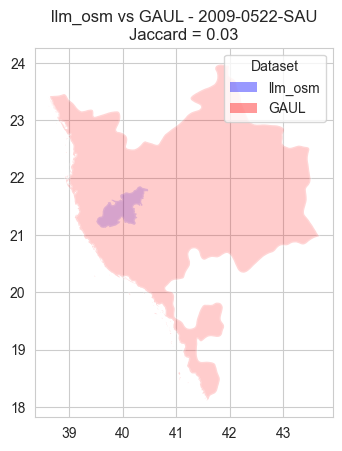

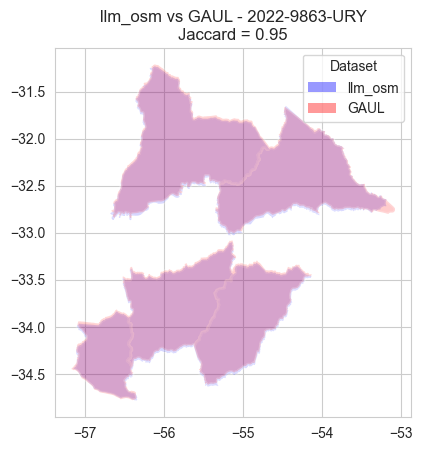

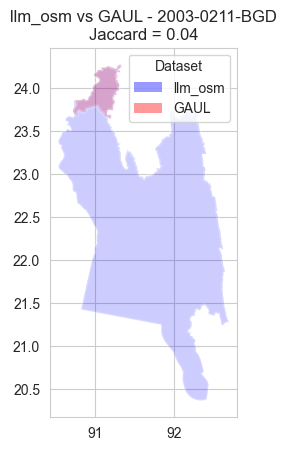

In [9]:
N_SAMPLES = 5

for i in range(N_SAMPLES):
    geom_source = random.choice(['llm_gadm', 'gdis_gadm', 'llm_osm', 'llm_wiki'])
    benchmark = random.choice(['GAUL', 'GDIS'])
    batch_number = random.randint(1, 5)
    while 'gdis' in geom_source and benchmark == 'GDIS':
        geom_source = random.choice(['llm_gadm', 'gdis_gadm', 'llm_osm', 'llm_wiki'])
        benchmark = random.choice(['GAUL', 'GDIS'])
    print(f"Generating sample {i+1}/{N_SAMPLES}: {geom_source} vs {benchmark} - batch {batch_number}")
    generate_visual_validation_df(
        geom_source=geom_source,
        benchmark=benchmark,
        batch_number=batch_number,
        seed=None
    )